In [2]:

# ============================================================
# EN3150 Assignment 03 – Task 2: Compare with State-of-the-Art Networks
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import json

# ============================================================
# 1. Load MNIST (UCI equivalent)
# ============================================================
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()
X_full = np.concatenate([x_train_full, x_test_full], axis=0)
y_full = np.concatenate([y_train_full, y_test_full], axis=0)

# Optional: use subset for Colab memory safety
subset_size = 15000       # use 10k–20k to fit RAM
X_full = X_full[:subset_size]
y_full = y_full[:subset_size]

# ============================================================
# 2. Split dataset 70/15/15
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.30, random_state=42, stratify=y_full
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# ============================================================
# 3. Preprocessing on-the-fly (memory efficient)
# ============================================================
IMG_SIZE = 224
BATCH = 64

def preprocess_grayscale_to_rgb(x, y):
    x = tf.expand_dims(x, -1)                  # (28,28,1)
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    x = tf.image.grayscale_to_rgb(x)           # (224,224,3)
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(10000)
            .map(preprocess_grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .map(preprocess_grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .map(preprocess_grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))



Train: 10500 Val: 2250 Test: 2250


In [3]:
# ============================================================
# 4. Custom CNN Model
# ============================================================
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=10,
                     x1=32, x2=64, x3=256, d=0.5):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(x1, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(x2, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(x3, activation='relu')(x)
    x = layers.Dropout(d)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out)

custom_model = build_custom_cnn()
custom_model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
custom_model.summary()

EPOCHS = 20
history_custom = custom_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ============================================================
# 5. Prepare datasets for ResNet and VGG (preprocessing)
# ============================================================
def map_resnet(x, y):
    return resnet_preprocess(x * 255.0), y

def map_vgg(x, y):
    return vgg_preprocess(x * 255.0), y

train_ds_resnet = train_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
val_ds_resnet   = val_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
test_ds_resnet  = test_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)

train_ds_vgg = train_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
val_ds_vgg   = val_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
test_ds_vgg  = test_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,186 (98.37 MB)

 Trainable params: 25,786,186 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.7664 - loss: 0.7365 - val_accuracy: 0.9600 - val_loss: 0.1288
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9570 - loss: 0.1537 - val_accuracy: 0.9698 - val_loss: 0.1002
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9677 - loss: 0.0942 - val_accuracy: 0.9742 - val_loss: 0.0997
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9840 - loss: 0.0575 - val_accuracy: 0.9773 - val_loss: 0.0778
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9834 - loss: 0.0507 - val_accuracy: 0.9760 - val_loss: 0.0819
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9790 - loss: 0.0621 - val_accuracy: 0.9773 - val_loss: 0.0756
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9900 - loss: 0.0245 - val_accuracy: 0.9782 - val_loss: 0.0819
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9941 - loss: 0

In [4]:
# ============================================================
# 6. ResNet50 Transfer Learning
# ============================================================
num_classes = 10
base_res = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_res.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_res(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
resnet_model = models.Model(inputs, outputs)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resnet_head = resnet_model.fit(train_ds_resnet, validation_data=val_ds_resnet, epochs=8)

# Fine-tune
base_res.trainable = True
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resnet_ft = resnet_model.fit(train_ds_resnet, validation_data=val_ds_resnet, epochs=12)



Epoch 1/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 285ms/step - accuracy: 0.6784 - loss: 1.0142 - val_accuracy: 0.9493 - val_loss: 0.1740
Epoch 2/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.9211 - loss: 0.2526 - val_accuracy: 0.9649 - val_loss: 0.1152
Epoch 3/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy: 0.9420 - loss: 0.1811 - val_accuracy: 0.9636 - val_loss: 0.1027
Epoch 4/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.9534 - loss: 0.1496 - val_accuracy: 0.9636 - val_loss: 0.1082
Epoch 5/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.9586 - loss: 0.1340 - val_accuracy: 0.9680 - val_loss: 0.0943
Epoch 6/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.9639 - loss: 0.1147 - val_accuracy: 0.9747 - val_loss: 0.0834
Epoch 7/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 40s 208ms/step - accuracy: 0.9644 - loss: 0.1090 - val_accuracy: 0.9769 - val_loss: 0.0700
Epoch 8/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 213ms/step - accuracy: 0.9708 - loss: 0.0873 - 

In [5]:
# ============================================================
# 7. VGG16 Transfer Learning
# ============================================================
def map_resnet(x, y):
    return resnet_preprocess(x * 255.0), y

def map_vgg(x, y):
    return vgg_preprocess(x * 255.0), y

train_ds_resnet = train_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
val_ds_resnet   = val_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
test_ds_resnet  = test_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)

train_ds_vgg = train_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
val_ds_vgg   = val_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
test_ds_vgg  = test_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
num_classes = 10
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_vgg.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_vgg(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
vgg_model = models.Model(inputs, outputs)

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg_head = vgg_model.fit(train_ds_vgg, validation_data=val_ds_vgg, epochs=8)

base_vgg.trainable = True
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg_ft = vgg_model.fit(train_ds_vgg, validation_data=val_ds_vgg, epochs=12)



Epoch 1/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 95s 417ms/step - accuracy: 0.5821 - loss: 1.6926 - val_accuracy: 0.9480 - val_loss: 0.1865
Epoch 2/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 59s 354ms/step - accuracy: 0.9061 - loss: 0.2971 - val_accuracy: 0.9613 - val_loss: 0.1310
Epoch 3/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 351ms/step - accuracy: 0.9429 - loss: 0.1814 - val_accuracy: 0.9662 - val_loss: 0.1091
Epoch 4/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.9530 - loss: 0.1427 - val_accuracy: 0.9684 - val_loss: 0.0974
Epoch 5/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 83s 356ms/step - accuracy: 0.9605 - loss: 0.1219 - val_accuracy: 0.9702 - val_loss: 0.0894
Epoch 6/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 349ms/step - accuracy: 0.9663 - loss: 0.1055 - val_accuracy: 0.9689 - val_loss: 0.0898
Epoch 7/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 59s 353ms/step - accuracy: 0.9746 - loss: 0.0860 - val_accuracy: 0.9729 - val_loss: 0.0825
Epoch 8/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.9712 - loss: 0.0829 - 

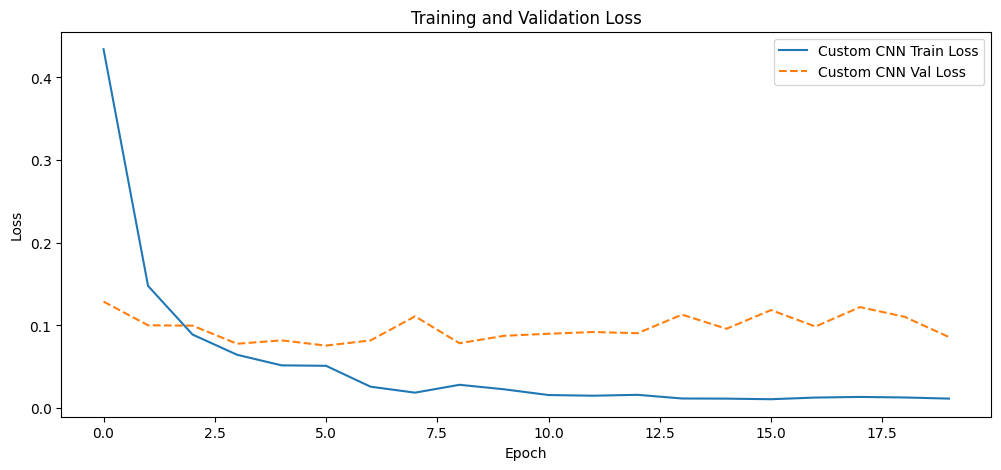

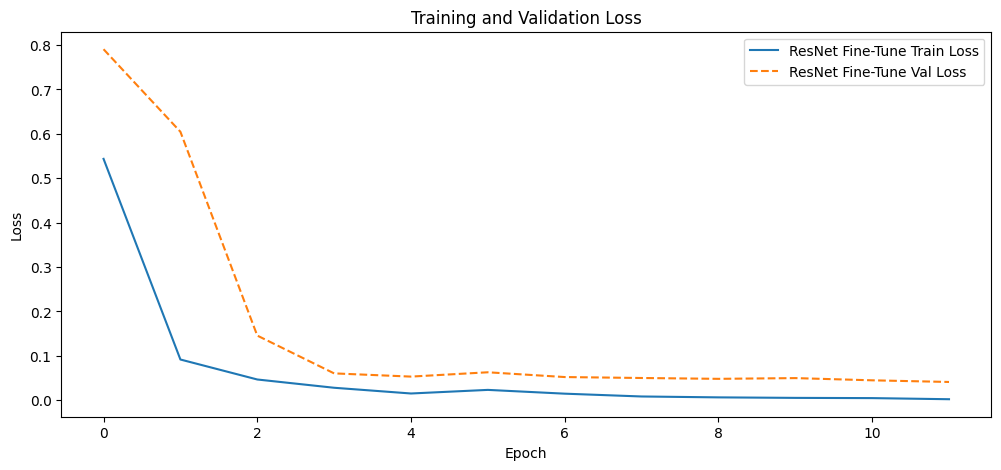

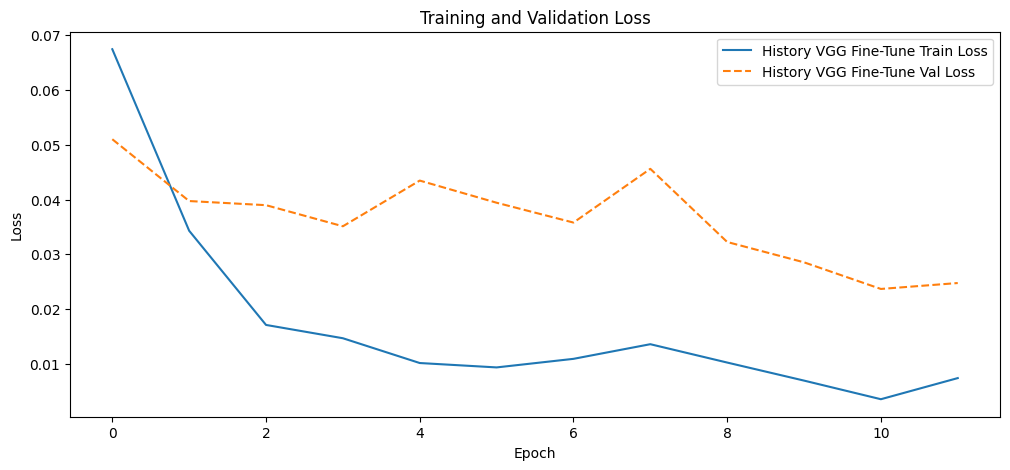

Shape of X_test_rgb before creating dataset: (2250, 224, 224, 3)
Shape of a batch from test_ds_custom: (64, 224, 224, 3)
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9708 - loss: 0.1356
Custom CNN Test accuracy: 0.9764444231987
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9902 - loss: 0.0357
ResNet50 Test accuracy: 0.9915555715560913
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - accuracy: 0.9853 - loss: 0.0673
VGG16 Test accuracy: 0.988444447517395
        Model  Test Accuracy
0  Custom CNN       0.976444
1    ResNet50       0.991556
2       VGG16       0.988444
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step

Custom CNN:
               precision    recall  f1-score   support

           0     0.9910    0.9866    0.9888       224
           1     0.9843    0.9882    0.9862       254
           2     0.9677    0.9589    0.9633       219
           3     0.9456    0.9741    0.9597       232
           4     0.9814    0.9591    0.9701       220
           5     0.9896    0.9645  

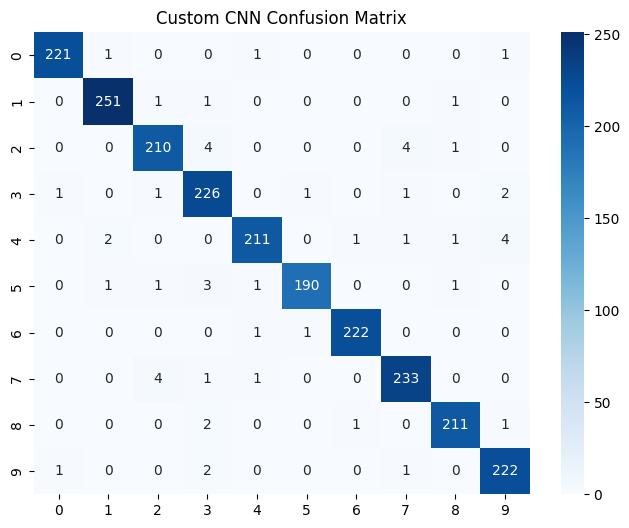

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step

ResNet50:
               precision    recall  f1-score   support

           0     0.9956    1.0000    0.9978       224
           1     1.0000    0.9961    0.9980       254
           2     0.9732    0.9954    0.9842       219
           3     0.9913    0.9871    0.9892       232
           4     0.9954    0.9909    0.9932       220
           5     0.9949    0.9848    0.9898       197
           6     0.9911    0.9955    0.9933       224
           7     0.9958    0.9874    0.9916       239
           8     0.9907    0.9953    0.9930       215
           9     0.9867    0.9823    0.9845       226

    accuracy                         0.9916      2250
   macro avg     0.9915    0.9915    0.9915      2250
weighted avg     0.9916    0.9916    0.9916      2250



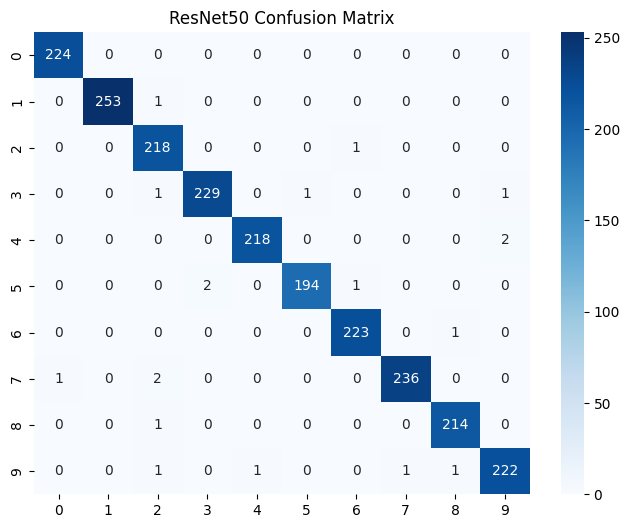

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step

VGG16:
               precision    recall  f1-score   support

           0     1.0000    0.9866    0.9933       224
           1     1.0000    0.9961    0.9980       254
           2     0.9518    0.9909    0.9709       219
           3     0.9871    0.9914    0.9892       232
           4     0.9909    0.9909    0.9909       220
           5     1.0000    0.9594    0.9793       197
           6     0.9955    0.9866    0.9910       224
           7     0.9916    0.9916    0.9916       239
           8     0.9907    0.9907    0.9907       215
           9     0.9783    0.9956    0.9868       226

    accuracy                         0.9884      2250
   macro avg     0.9886    0.9880    0.9882      2250
weighted avg     0.9887    0.9884    0.9885      2250



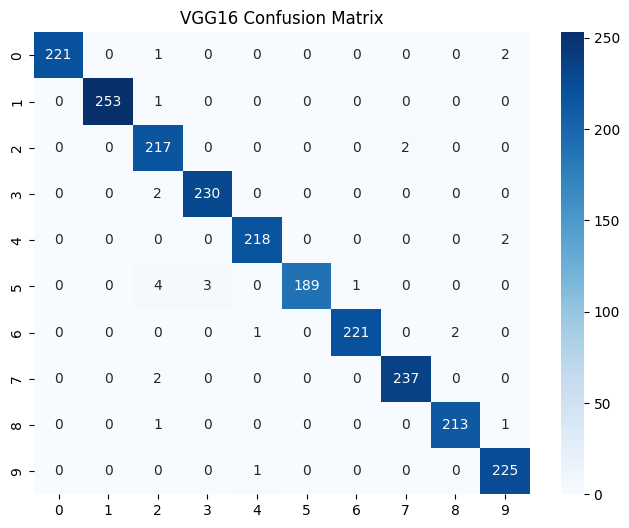

In [6]:
# ============================================================
# 8. Plot training/validation losses
# ============================================================

def plot_history(histories, titles):
    plt.figure(figsize=(12,5))
    for h, t in zip(histories, titles):
        plt.plot(h.history['loss'], label=f'{t} Train Loss')
        plt.plot(h.history['val_loss'], '--', label=f'{t} Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.title('Training and Validation Loss')
    plt.show()

# Note: history_custom is from the custom CNN model training
# history_resnet_head and history_resnet_ft are from ResNet50 training
# history_vgg_head and history_vgg_ft are from VGG16 training

# Plot losses for Custom CNN
if 'history_custom' in locals() and history_custom is not None:
    plot_history([history_custom], ['Custom CNN'])

# Plot losses for ResNet50 (fine-tuned) if available
if 'history_resnet_ft' in locals() and history_resnet_ft is not None:
    plot_history([history_resnet_ft], ['ResNet Fine-Tune'])

# Plot losses for VGG16 (fine-tuned) if available
if 'history_vgg_ft' in locals() and history_vgg_ft is not None:
    plot_history([history_vgg_ft], ['History VGG Fine-Tune'])


# ============================================================
# 9. Evaluate and Compare Models
# ============================================================
# Apply preprocessing to test_ds for the custom model evaluation
# Ensure IMG_SIZE is 224 for custom model evaluation
IMG_SIZE_EVAL = 224 # Use a different variable name for clarity

# Explicitly resize X_test before creating the dataset
X_test_resized = tf.image.resize(tf.expand_dims(X_test, -1), [IMG_SIZE_EVAL, IMG_SIZE_EVAL]).numpy()
X_test_rgb = tf.image.grayscale_to_rgb(tf.constant(X_test_resized, dtype=tf.float32)).numpy() / 255.0

# Add print statement to check the shape of X_test_rgb
print("Shape of X_test_rgb before creating dataset:", X_test_rgb.shape)

test_ds_custom = (tf.data.Dataset.from_tensor_slices((X_test_rgb, y_test))
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))


# Add print statement to check the shape of the data from the dataset
for images, labels in test_ds_custom.take(1):
    print("Shape of a batch from test_ds_custom:", images.shape)

test_loss_c, test_acc_c = custom_model.evaluate(test_ds_custom)
print("Custom CNN Test accuracy:", test_acc_c)

test_loss_r, test_acc_r = resnet_model.evaluate(test_ds_resnet)
print("ResNet50 Test accuracy:", test_acc_r)

test_loss_v, test_acc_v = vgg_model.evaluate(test_ds_vgg)
print("VGG16 Test accuracy:", test_acc_v)

summary = pd.DataFrame({
    'Model': ['Custom CNN', 'ResNet50', 'VGG16'],
    'Test Accuracy': [test_acc_c, test_acc_r, test_acc_v]
})
print(summary)

# ============================================================
# 10. Classification report & confusion matrix (optional)
# ============================================================
# Regenerate y_true based on the correctly preprocessed test_ds for the custom model
y_true_custom = np.concatenate([y for _, y in test_ds_custom], axis=0)

y_pred_c = np.argmax(custom_model.predict(test_ds_custom), axis=1)
print("\nCustom CNN:\n", classification_report(y_true_custom, y_pred_c, digits=4))
cm_c = confusion_matrix(y_true_custom, y_pred_c)
plt.figure(figsize=(8, 6)) # Added figure size for better visualization
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Blues')
plt.title('Custom CNN Confusion Matrix'); plt.show()

# For ResNet50 evaluation
y_true_resnet = np.concatenate([y for _, y in test_ds_resnet], axis=0)
y_pred_r = np.argmax(resnet_model.predict(test_ds_resnet), axis=1)
print("\nResNet50:\n", classification_report(y_true_resnet, y_pred_r, digits=4))
cm_r = confusion_matrix(y_true_resnet, y_pred_r)
plt.figure(figsize=(8, 6)) # Added figure size for better visualization
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues')
plt.title('ResNet50 Confusion Matrix'); plt.show()

# For VGG16 evaluation
y_true_vgg = np.concatenate([y for _, y in test_ds_vgg], axis=0)
y_pred_v = np.argmax(vgg_model.predict(test_ds_vgg), axis=1)
print("\nVGG16:\n", classification_report(y_true_vgg, y_pred_v, digits=4))
cm_v = confusion_matrix(y_true_vgg, y_pred_v)
plt.figure(figsize=(8, 6)) # Added figure size for better visualization
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues')
plt.title('VGG16 Confusion Matrix'); plt.show()

In [ ]:
# Clone the repo
!git clone https://github.com/Neuro-Matrix-EN3150/Assignment-03-CNN-for-image-classification.git

# Change into repo folder
%cd Assignment-03-CNN-for-image-classification

# Copy your notebook
!cp /content/YourNotebook.ipynb .

# Configure Git
!git config --global user.email "jatheess478@gmail.com"
!git config --global user.name "Jathees"

# Add & commit
!git add .
!git commit -m "Add Colab notebook for assignment 03"

# Push to GitHub
!git push https://<Jathees985>:<YOUR_PERSONAL_ACCESS_TOKEN>@github.com/Neuro-Matrix-EN3150/Assignment-03-CNN-for-image-classification.git
